In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pandas.testing import assert_frame_equal
#from pysankey2 import Sankey
from scipy import stats
#from pysankey2.datasets import load_fruits
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from scipy.spatial.distance import pdist
import random as rd
import time
#from psankey.sankey import sankey
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import SparseCoder
from sklearn import metrics
import palettable

In [5]:
sc.set_figure_params(dpi = 300, color_map = 'viridis_r' )
sc.settings.verbosity = 2

# Loading Data

In [3]:
cancer_type = 'HCC_ICC'

In [4]:
cnv_score_all_cell = pd.read_csv(cancer_type + '_CNV_neighbor_all.csv', index_col=0)
cnv_score_all_cell = cnv_score_all_cell.round(4)
cnv_score_all_cell = cnv_score_all_cell.dropna(axis=1, how='any')

anno = pd.read_csv('/mnt/hdd1/jikai/hhseq_processing_latest/inferCNV_per_cancer_type/' + cancer_type + '_all/' + 
                   cancer_type + '_overall_anno.csv', index_col=0)

# Hierarchical Clustering (Inner): PCA

In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

In [6]:
cnv_inner_pca_raw = cnv_score_all_cell.copy()

In [7]:
start = time.time()

#pca = PCA(n_components=0.9)
pca = PCA(n_components=50)

cnv_inner_pca = pca.fit_transform(cnv_inner_pca_raw)

end = time.time()

print('%.4f' % (end-start))

22.1022


In [8]:
cnv_inner_pca.shape

(166296, 50)

In [9]:
cnv_inner_pca_raw.shape

(166296, 3529)

In [10]:
start = time.time()

Y_inner = pdist(cnv_inner_pca, metric='euclidean')

end = time.time()

print('%.4f' % (end-start))

2236.5213


In [11]:
start = time.time()

Z_inner = linkage(Y_inner, 'ward')

end = time.time()

print('%.4f' % (end-start))

2441.7453


In [12]:
start = time.time()

fig = plt.figure(figsize=(40, 10))
dn_inner = dendrogram(Z_inner)

end = time.time()

print('%.4f' % (end-start))

227.4848


In [16]:
#start = time.time()

cutoff_inner = 80
cluster_extracted_inner = fcluster(Z_inner, t=cutoff_inner, criterion='distance')
np.unique(cluster_extracted_inner.tolist())

#end = time.time()

#print('%.4f' % (end-start))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
cluster_extracted_df = pd.DataFrame(index = cnv_score_all_cell.index)
cluster_extracted_df['cluster'] = cluster_extracted_inner.tolist()
cluster_extracted_df.to_csv(cancer_type + '_all_cell_cluster_pca_used.csv')

In [18]:
anno['patient_id'] = anno['leiden_patient'].str.split('|', expand=True)[1]
anno = anno.loc[cluster_extracted_df.index.tolist(), :]
cluster_extracted_df['patient_id'] = anno['patient_id']

In [19]:
cluster_stat_all = pd.DataFrame()

for each_tissue in np.unique(cluster_extracted_df['patient_id']).tolist():
    
    each_tissue_stat = pd.DataFrame(cluster_extracted_df[cluster_extracted_df['patient_id'] == each_tissue]['cluster'].value_counts())
    each_tissue_stat.columns = [each_tissue]
    cluster_stat_all = pd.concat([each_tissue_stat, cluster_stat_all], axis = 1)

<AxesSubplot:>

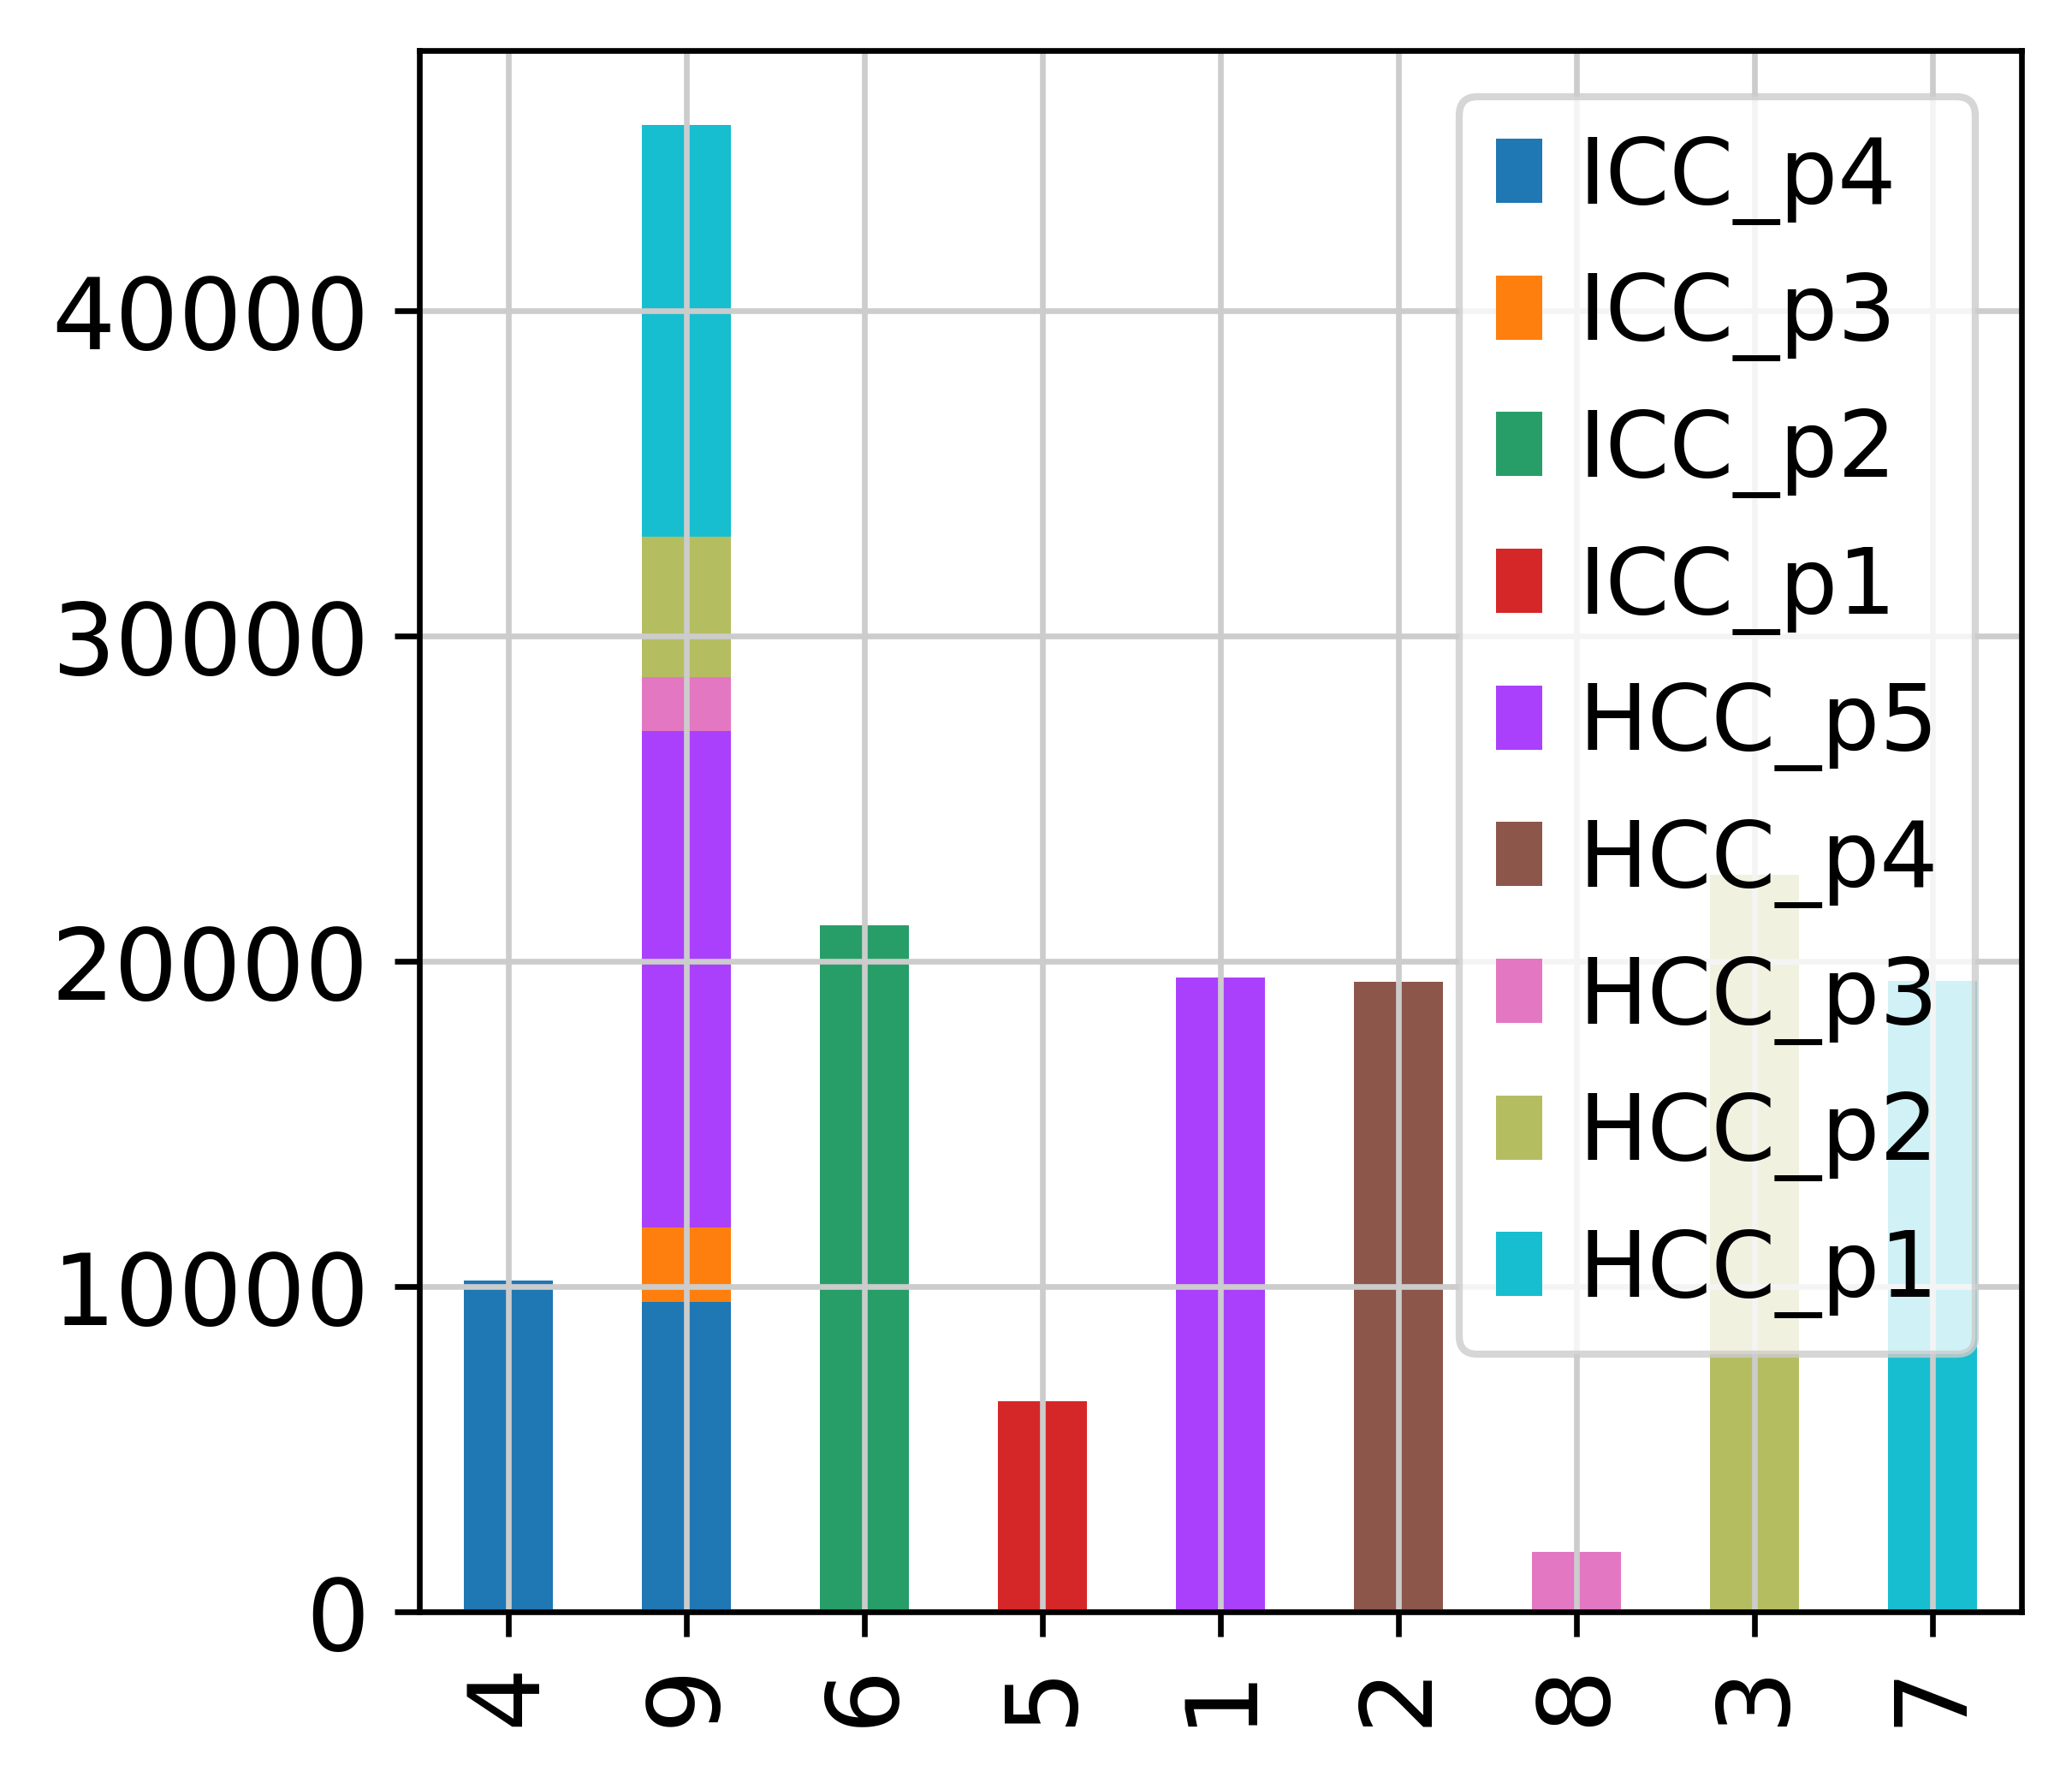

In [20]:
cluster_stat_all.plot(kind = 'bar', stacked = True)

In [21]:
cluster_subset = []

for each_cluster in np.unique(cluster_extracted_df['cluster']).tolist():
    
    cluster_subset.extend(rd.sample(cluster_extracted_df[cluster_extracted_df['cluster'] == each_cluster].index.tolist(), 1000))

cluster_subset = cluster_extracted_df.loc[cluster_subset, :].copy()
cluster_subset = cluster_subset.sort_values('cluster')

cnv_score_subsample = cnv_score_all_cell.copy()
cnv_score_subsample = cnv_score_subsample.loc[cluster_subset.index.tolist(), :]

In [22]:
gene_loc = pd.read_csv('/mnt/hdd1/jikai/cnv_test/gene_loc.tsv', sep = '\t', header=None, index_col=0)
gene_loc_max = gene_loc[2].max() + 1
gene_loc['modified_loc'] = gene_loc[1] * gene_loc_max + gene_loc[2]

gene_order = pd.DataFrame(index = cnv_score_subsample.columns.tolist())
for i in gene_order.index.tolist():
    

    gene_order.loc[i, 'order'] = gene_loc.loc[i, 'modified_loc']
    gene_order.loc[i, 'chr'] = str(gene_loc.loc[i, 1])
    
gene_order = gene_order.sort_values('order')
gene_order['chr'] = gene_order['chr'].astype(str)
gene_order['order'] = list(range(0, gene_order.shape[0]))
cnv_score_subsample = cnv_score_subsample.loc[:, gene_order.index.tolist()]

<AxesSubplot:>

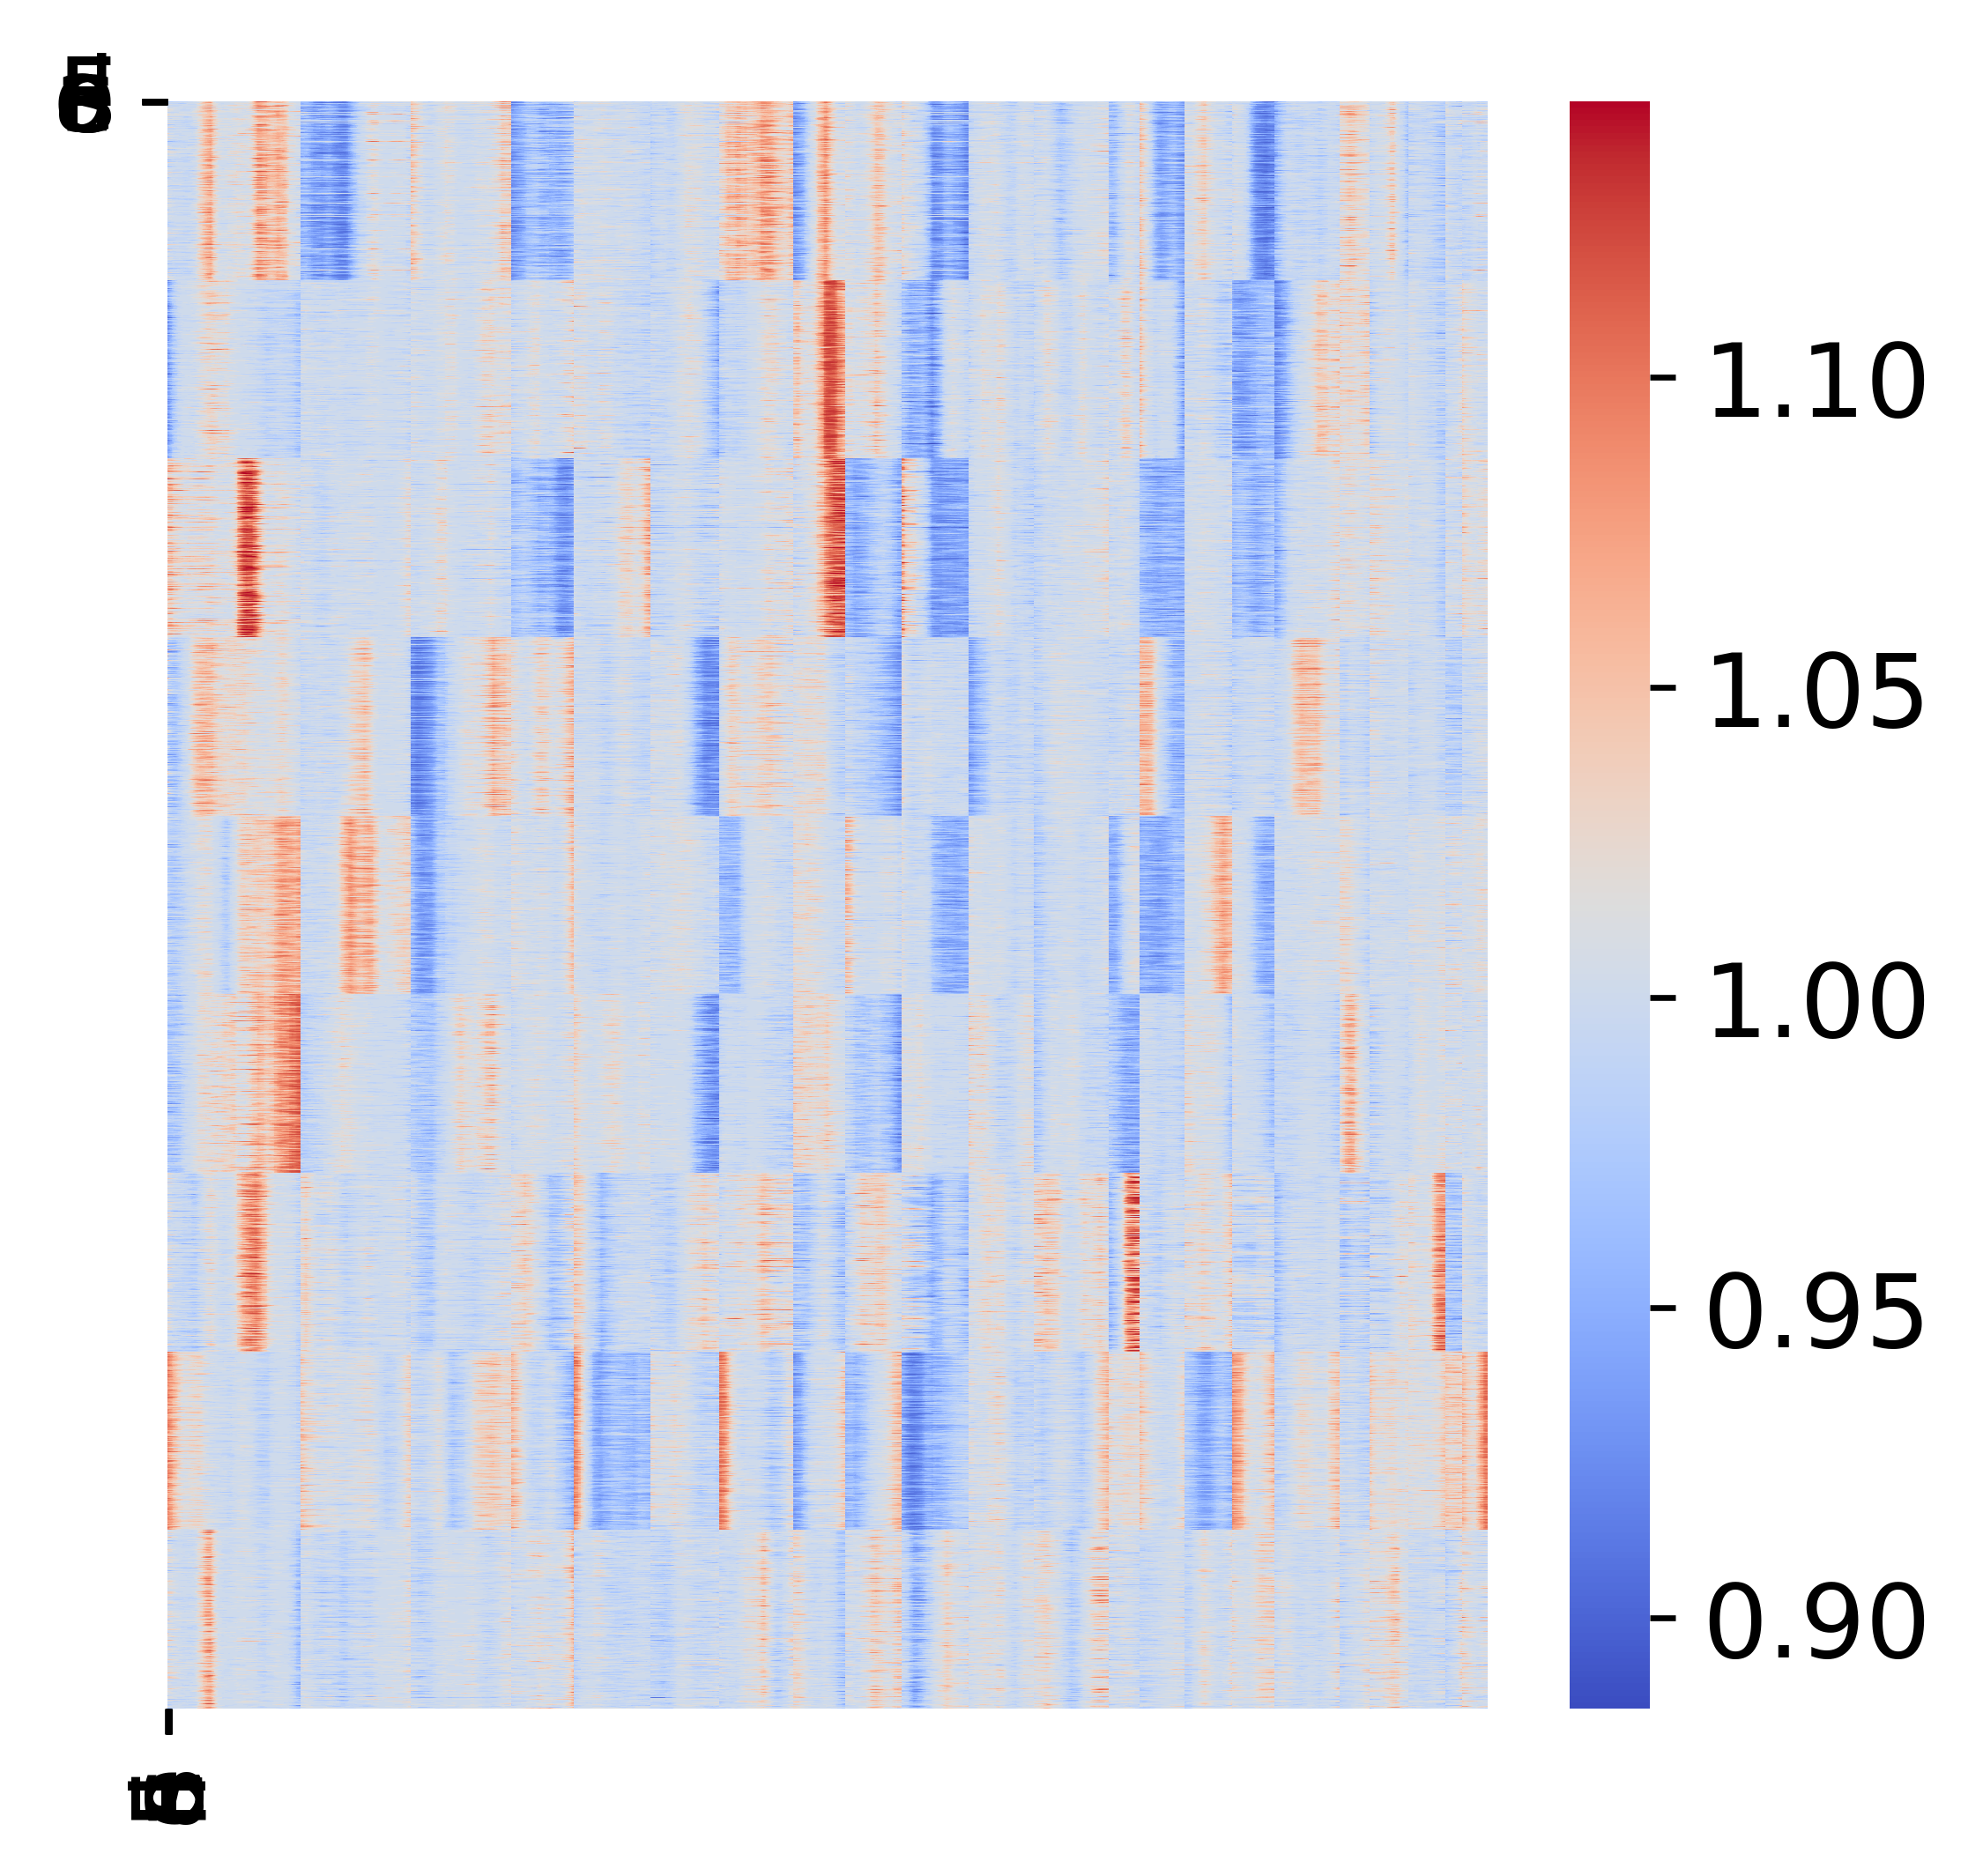

In [23]:
sns.heatmap(cnv_score_subsample, xticklabels='False', yticklabels='False', cmap='coolwarm')

# Subsampling for display:

In [6]:
cancer_type = 'HCC_ICC'

In [9]:
cluster_all = pd.read_csv(cancer_type + '_all_cell_cluster_pca_used.csv', index_col=0)
neighbor_all = pd.read_csv(cancer_type + '_CNV_neighbor_all.csv', index_col=0)
neighbor_all = neighbor_all.round(4)
neighbor_all = neighbor_all.dropna(axis=1, how='any')

In [28]:
cluster_subset = []

for each_cluster in np.unique(cluster_all['cluster']).tolist():
    
    cluster_subset.extend(rd.sample(cluster_all[cluster_all['cluster'] == each_cluster].index.tolist(), 500))

cluster_subset = cluster_all.loc[cluster_subset, :].copy()
cluster_subset = cluster_subset.sort_values('cluster')

neighbor_all_subsample = neighbor_all.copy()
neighbor_all_subsample = neighbor_all_subsample.loc[cluster_subset.index.tolist(), :]

In [29]:
gene_loc = pd.read_csv('gene_loc.tsv', sep = '\t', header=None, index_col=0)
gene_loc_max = gene_loc[2].max() + 1
gene_loc['modified_loc'] = gene_loc[1] * gene_loc_max + gene_loc[2]

gene_order = pd.DataFrame(index = neighbor_all_subsample.columns.tolist())

for i in gene_order.index.tolist():

    gene_order.loc[i, 'order'] = gene_loc.loc[i, 'modified_loc']
    gene_order.loc[i, 'chr'] = str(gene_loc.loc[i, 1])
    
gene_order = gene_order.sort_values('order')
gene_order['chr'] = gene_order['chr'].astype(str)
gene_order['order'] = list(range(0, gene_order.shape[0]))
neighbor_all_subsample = neighbor_all_subsample.loc[:, gene_order.index.tolist()]

<AxesSubplot:>

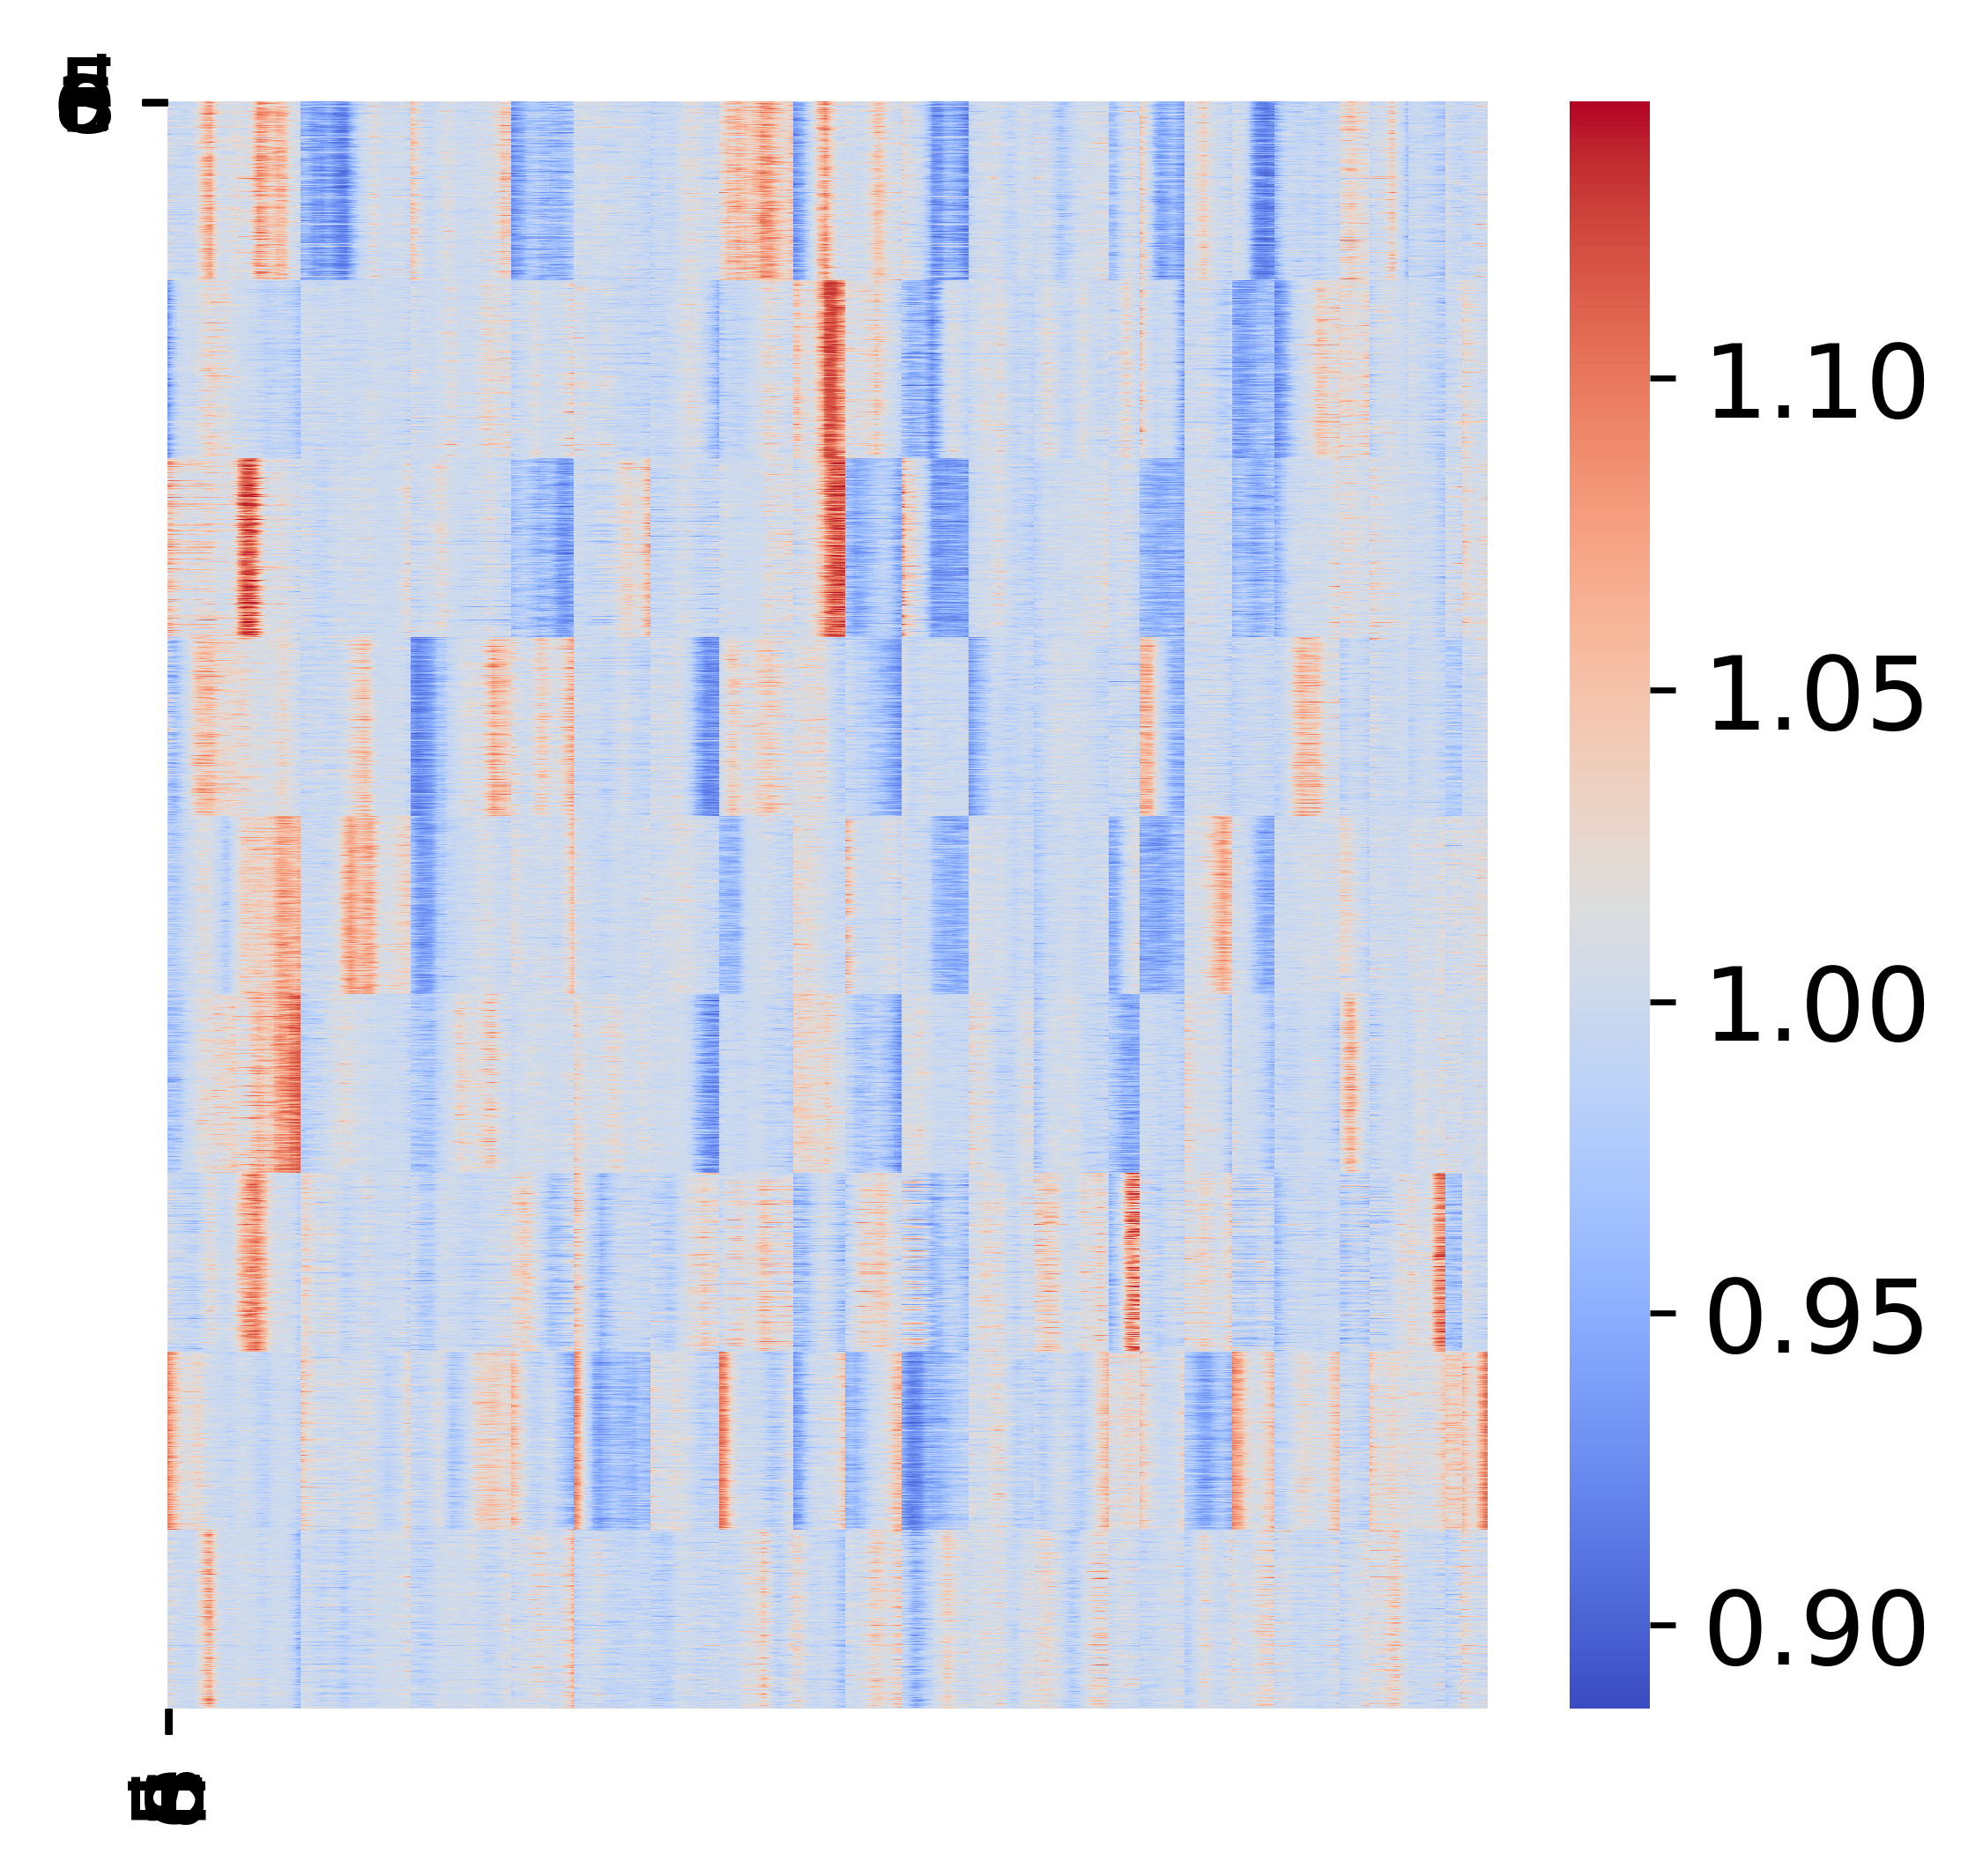

In [30]:
sns.heatmap(neighbor_all_subsample, xticklabels='False', yticklabels='False', cmap='coolwarm')

In [33]:
ref_celltype_subsampled = pd.read_csv('old/' + cancer_type + '_cnv_ref_celltype_subsample.csv', index_col=0)
ref_subsampled = pd.read_csv('old/' + cancer_type + '_cnv_score_ref_subsample.csv', index_col=0)

check = pd.DataFrame(ref_subsampled.columns.tolist())
check_2 = pd.DataFrame(neighbor_all_subsample.columns.tolist())
check[1] = check_2[0]

for i in check.index.tolist():
    
    if check.loc[i, 0] != check.loc[i, 1]:
        
        print(i)

In [51]:
anno_latest = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/hhseq_all_cell_anno_latest.csv', index_col=0)
anno_latest = anno_latest.loc[cluster_subset.index.tolist(), :]

cluster_subset['patient_id'] = anno_latest['patient_id']

/tmp/ipykernel_28243/847194384.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  anno_latest = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/hhseq_all_cell_anno_latest.csv', index_col=0)


In [47]:
neighbor_all_subsample.to_csv(cancer_type + '_cnv_score_inner_cluster_subsample.csv')
cluster_subset.to_csv(cancer_type + '_cnv_cluster_subsample.csv')
gene_order.to_csv(cancer_type + '_gene_order.csv')